<a href="https://colab.research.google.com/github/AsyrofiAnam/-Asyrofi-Anam-TugasMachineLearning/blob/main/jst_cnn_klasifikasi_buah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library dan Persiapan Direktori

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os
import warnings
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

#Persiapan Data

In [ ]:
# Path input dan direktori dataset
input_dir = "/content/drive/MyDrive/JST/input/fruits-360/Training"
if os.path.exists(input_dir):
    print(f"Isi folder '{input_dir}':")
    print(os.listdir(input_dir))
else:
    print(f"Folder '{input_dir}' tidak ditemukan. Pastikan struktur direktori Anda benar.")

# Direktori dan kelas buah yang dipilih
directory = "/content/drive/MyDrive/JST/input/fruits-360/Training"
classes = ["Apel", "Jeruk", "Semangka"]
all_arrays = []
img_size = 100

# Persiapan data pelatihan
for i in classes:
    path = os.path.join(directory, i)
    if os.path.exists(path):
        class_num = classes.index(i)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            if os.path.isfile(img_path):
                img_array = cv2.imread(img_path)
                if img_array is not None:
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    img_array = cv2.resize(img_array, (img_size, img_size))
                    all_arrays.append([img_array, class_num])

print(f"Total data gambar: {len(all_arrays)}")

Isi folder '/content/drive/MyDrive/JST/input/fruits-360/Training':
['Apel', 'Jeruk', 'Semangka']
Total data gambar: 1446


#Visualisasi Data

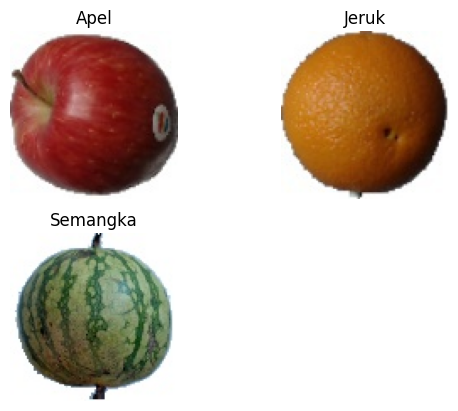

In [ ]:
for i in range(3):
    plt.subplot(2, 2, i+1)
    class_images = [img_array for img_array, label in all_arrays if label == i]
    sample_img = class_images[0]  # Pilih gambar pertama dari kelas
    plt.imshow(sample_img)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

#Pemrosesan Data dan Split

In [ ]:
import random
random.shuffle(all_arrays)

X_train = []
Y_train = []
for features, label in all_arrays:
    X_train.append(features)
    Y_train.append(label)

X_train = np.array(X_train)
X_train = X_train.reshape(-1, img_size, img_size, 3)
X_train = X_train / 255

# One-hot encoding untuk label
y_train = to_categorical(Y_train, num_classes=3)

# Membagi data untuk pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Augmentasi Data
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.5,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(x_train)

#Definisi Model CNN dengan L2 Regularization

In [ ]:
model = Sequential()

# Layer pertama dengan L2 regularization
model.add(Conv2D(filters=8, kernel_size=(3, 3), padding="Same", activation="relu", input_shape=(100, 100, 3), kernel_regularizer=l2(0.001)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=l2(0.001)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=l2(0.001)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))

# Optimizer dan kompilasi
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#EarlyStopping dan Pelatihan Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(datagen.flow(x_train, y_train, batch_size=18),
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.4030 - loss: 1.6817 - val_accuracy: 0.9828 - val_loss: 0.9268
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.8143 - loss: 0.7225 - val_accuracy: 1.0000 - val_loss: 0.3496
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9749 - loss: 0.3646 - val_accuracy: 1.0000 - val_loss: 0.2684
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.9950 - loss: 0.2567 - val_accuracy: 1.0000 - val_loss: 0.2109
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9980 - loss: 0.2129 - val_accuracy: 1.0000 - val_loss: 0.1969
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.9974 - loss: 0.1754 - val_accuracy: 1.0000 - val_loss: 0.1516
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9952 - loss: 0.1574 - val_accuracy: 1.0000 - val_loss: 0.1459
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.9986 - loss: 0.1357 - val_accu

#Evaluasi Model pada Data Test

In [ ]:
test_dir = "/content/drive/MyDrive/JST/input/fruits-360/Test"
test_images = []
test_labels = []
for i in classes:
    path = os.path.join(test_dir, i)
    class_num = classes.index(i)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        if os.path.isfile(img_path):
            img_array = cv2.imread(img_path)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img_array, (img_size, img_size))
            test_images.append(img_array)
            test_labels.append(class_num)

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, num_classes=3)
test_images = test_images / 255

# Prediksi data test
test_predictions = model.predict(test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_classes = np.argmax(test_labels, axis=1)

# Menghitung metrik
accuracy = accuracy_score(test_classes, test_pred_classes)
precision = precision_score(test_classes, test_pred_classes, average='weighted')
recall = recall_score(test_classes, test_pred_classes, average='weighted')
f1 = f1_score(test_classes, test_pred_classes, average='weighted')

# Menampilkan hasil evaluasi
print("Evaluasi Model pada Data Test:")
print(f"Akurasi   : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1-Score  : {f1:.2f}")

# Menampilkan laporan klasifikasi
print("\nLaporan Klasifikasi pada Data Test:\n")
print(classification_report(test_classes, test_pred_classes, target_names=classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
Evaluasi Model pada Data Test:
Akurasi   : 0.88
Precision : 0.90
Recall    : 0.88
F1-Score  : 0.87

Laporan Klasifikasi pada Data Test:

              precision    recall  f1-score   support

        Apel       0.75      1.00      0.86        70
       Jeruk       0.97      0.99      0.98        70
    Semangka       0.98      0.64      0.78        70

    accuracy                           0.88       210
   macro avg       0.90      0.88      0.87       210
weighted avg       0.90      0.88      0.87       210



# Manampilkan confusion matrix

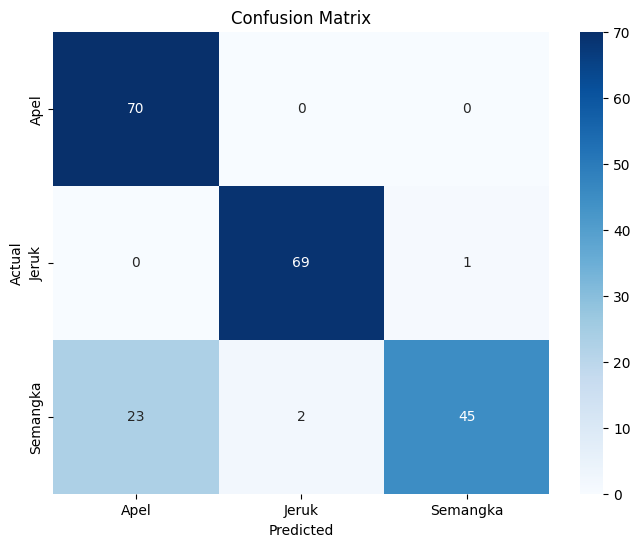

In [ ]:
cm = confusion_matrix(test_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Menampilkan Grafik Akurasi

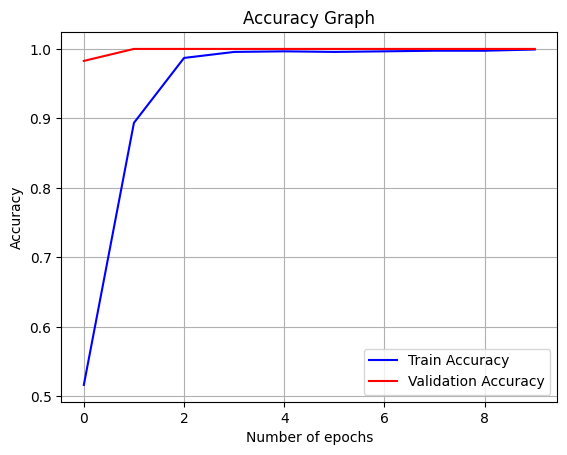

In [ ]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

#Prediksi Gambar Baru

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


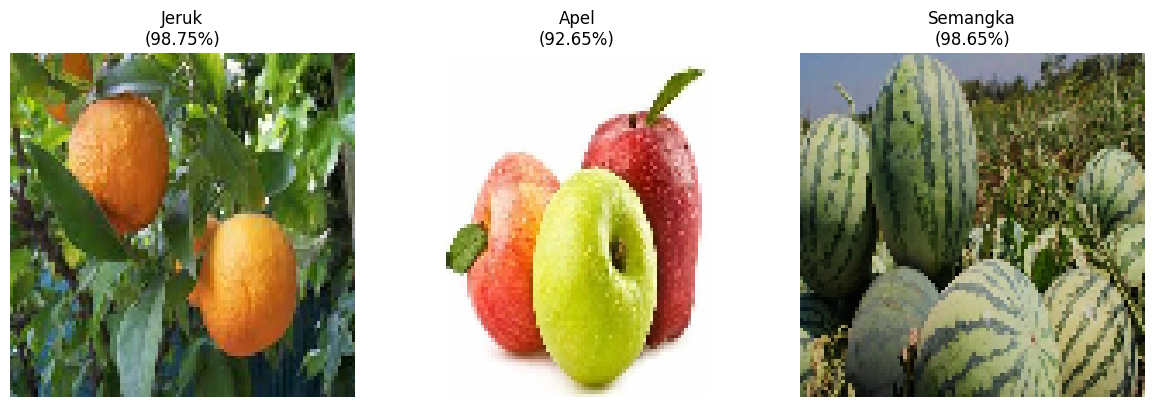

In [ ]:
def predict_images(image_paths, model, classes, img_size=100):
    plt.figure(figsize=(12, 4))
    for idx, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        if img is None: continue
        img = cv2.cvtColor(cv2.resize(img, (img_size, img_size)), cv2.COLOR_BGR2RGB) / 255.0
        prediction = model.predict(np.expand_dims(img, axis=0))
        predicted_class = classes[np.argmax(prediction)]

        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.title(f"{predicted_class}\n({np.max(prediction)*100:.2f}%)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Prediksi gambar baru
image_paths = [
    "/content/drive/MyDrive/JST/prediksi/jeruk.jpg",  # Path gambar Jeruk
    "/content/drive/MyDrive/JST/prediksi/apel.jpg",   # Path gambar Apel
    "/content/drive/MyDrive/JST/prediksi/semangka.jpg"  # Path gambar Semangka
]

predict_images(image_paths, model, classes)
